## VAE Hawkes Process Estimation - Tutorial

In [1]:
import os

import numpy as np
import pandas as pd
import scienceplots

import matplotlib.pyplot as plt

from dl.mlp_model import MLPTrainer
import variables.prep_var as prep

from evaluation.eval import compute_errors
from hawkes.simulation import hawkes_simulations, hawkes_simulation
from hawkes.discretisation import discretise
from hawkes.hyperparameters import hyper_params_simulation
from tools.utils import write_parquet, read_parquet, timer
from visualization.error_viz import convergence_rate, error_boxplots, delta_boxplots
from preprocessing.dataset import split_data, create_datasets, create_data_loaders

%load_ext autoreload
%autoreload 2

### Preprocessing

In [44]:
# Training/Validation/Testing dataset generation

# Intensity Decay Parameter (β) = U(p = 1, q = 3)
# Branching Ratio (η) = U(a = 0.05, b = 0.8)
# Expected Activity (E) = 500
# Time Horizon (T) = 100
# Interval Length (∆) = 1
# Number of processes = 100_000

# Hawkes process hyper-parameters generation
params, alpha, beta, eta, mu = hyper_params_simulation(filename="hawkes_hyperparams.parquet")

# Hawkes processes simulations
simulated_events_seqs = hawkes_simulations(alpha, beta, mu, filename="hawkes_simulations.parquet")

# Discrétiser les processus de Hawkes
discret_simulated_events_seqs = discretise(simulated_events_seqs, filename="binned_hawkes_simulations.parquet")

### Training

In [2]:
# Data Preparation (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("delta_mlp/binned_hawkes_simulations_train_delta_0.25.parquet")
y = read_parquet("delta_mlp/hawkes_hyperparams_train_delta_0.25.parquet")

train_x, train_y, val_x, val_y, test_x, test_y = split_data(x, y[['eta', 'mu']]) 
train_dataset, val_dataset, test_dataset = create_datasets(train_x, train_y, val_x, val_y, test_x, test_y)
train_loader, val_loader, test_loader = create_data_loaders(train_dataset, val_dataset, test_dataset)

In [3]:
# Trained model

model, train_losses, val_losses, val_y_pred, val_eta, val_mu = MLPTrainer().train_model(train_loader, val_loader, val_x, val_y)
%load_ext tensorboard

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Kernel Shape              Mult-Adds                 Trainable
MLP                                      [10000, 400]              [10000, 2]                --                             --                   --                        --                        True
├─Linear: 1-1                            [10000, 400]              [10000, 400]              160,400                    14.28%                   --                        1,604,000,000             True
├─ModuleList: 1-2                        --                        --                        --                             --                   --                        --                        True
│    └─Sequential: 2-1                   [10000, 400]              [10000, 400]              --                             --                   --                        --              

Epoch 500/500 - train_loss: 0.0587, val_loss: 0.1205: 100%|██████████| 500/500 [5:07:43<00:00, 36.93s/it]  


Best model loading (2023_05_18_16_21_07_MICSHPEG8GIRARD_best_model.pt)...
Validation set - Estimated branching ratio (η): 0.4018, Estimated baseline intensity (µ): 3.0121


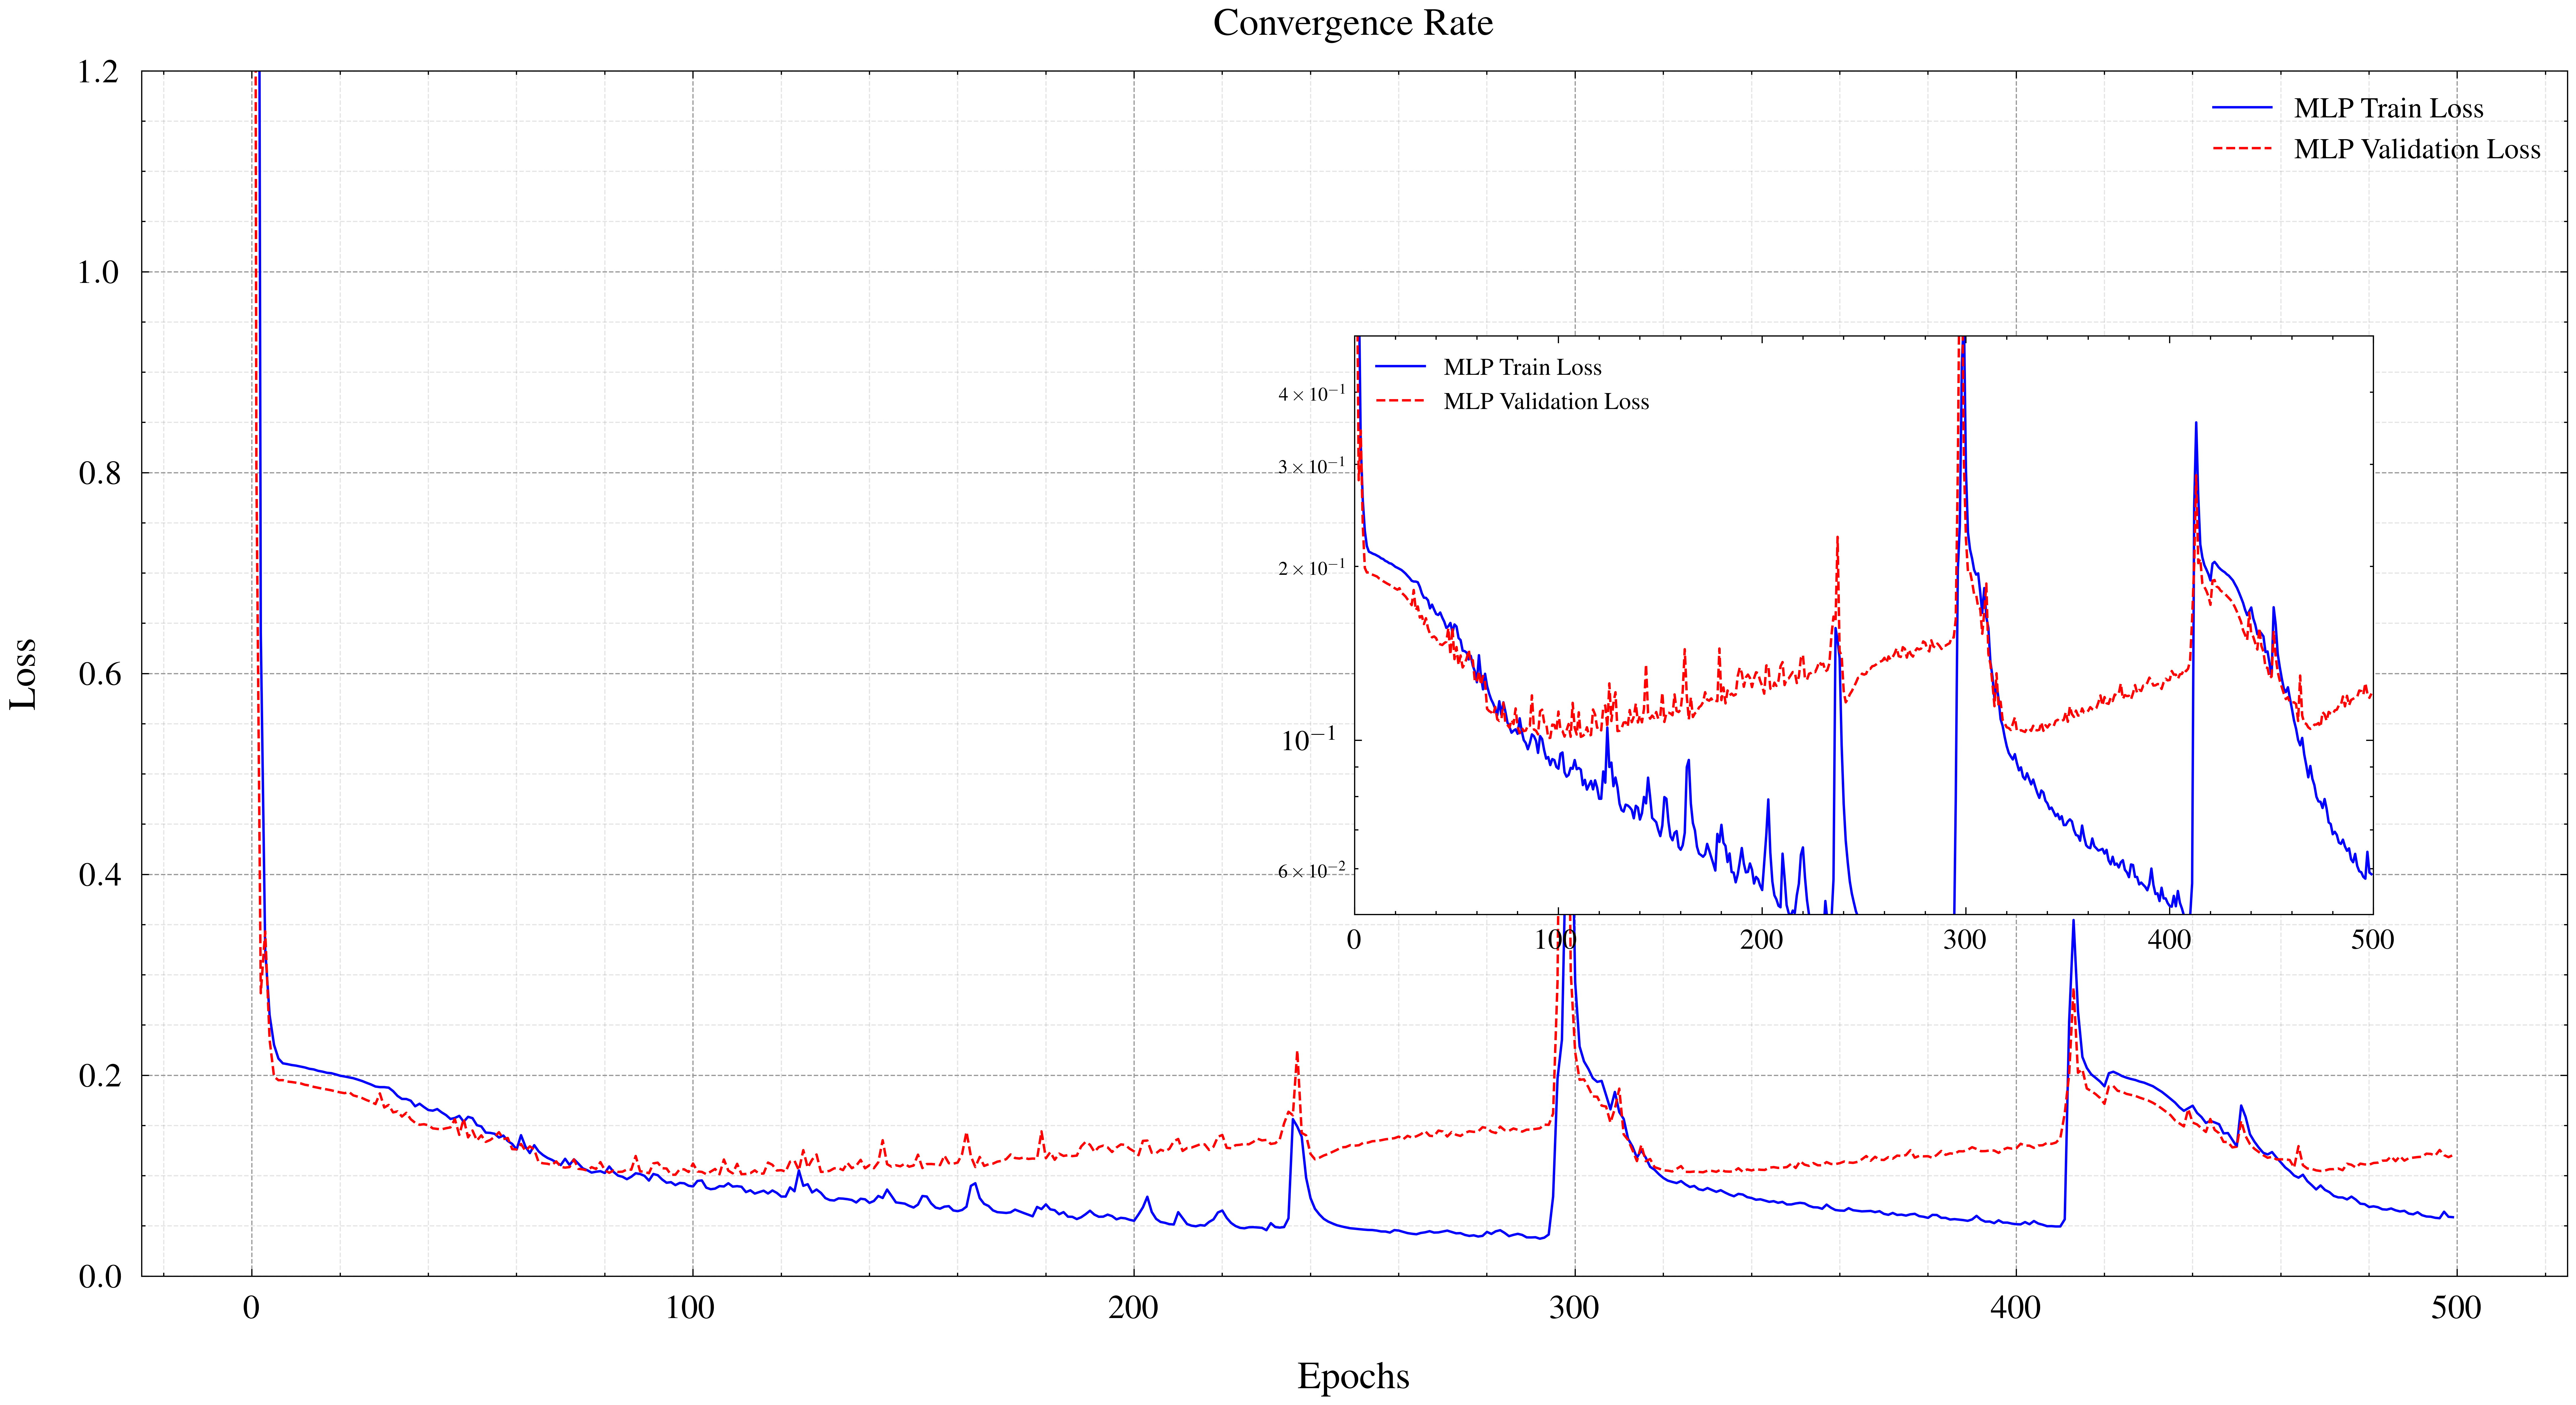

In [4]:
# Convergence rate plots

# bench_losses = read_parquet('benchmark/losses_benchmark.parquet')
mlp_losses = read_parquet('delta_mlp/losses_mlp_delta_0.25.parquet')

convergence_rate(losses=[mlp_losses], models=["MLP"], colors=["blue", "red"])

### Testing

In [5]:
# Tested model (if pandas: y = y.iloc[:, [0, 2]] in split_data + alpha = eta in hawkes library)

x = read_parquet("delta_mlp/binned_hawkes_simulations_delta_0.25.parquet")
y = read_parquet("delta_mlp/hawkes_hyperparams_delta_0.25.parquet")

test_x, test_y, _, _, _, _ = split_data(x, y[['eta', 'mu']])
test_y_pred, _, _ = MLPTrainer().test_model(test_x, test_y)
%load_ext tensorboard

Best model loading (2023_05_18_16_21_07_MICSHPEG8GIRARD_best_model.pt)...
Test set - Estimated branching ratio (η): 0.4020, Estimated baseline intensity (µ): 3.0107
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Evaluation

In [6]:
# Computed absolute/relative error + boxplots

# bench_pred = read_parquet('predictions_benchmark.parquet')
mlp_pred = read_parquet('delta_mlp/predictions_mlp_delta_0.25.parquet')

# bench_errors = compute_errors(bench_pred[['eta_true', 'mu_true']], bench_pred[['eta_pred', 'mu_pred']])
mlp_errors = compute_errors(mlp_pred[['eta_true', 'mu_true']], mlp_pred[['eta_pred', 'mu_pred']], model_name='MLP')

error_boxplots(errors=[mlp_errors], label_names=["MLP"])

shape: (1, 5)
┌───────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---   ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str   ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP   ┆ 0.0029            ┆ 0.0042            ┆ 0.0557  ┆ 0.0198  │
└───────┴───────────────────┴───────────────────┴─────────┴─────────┘


### Delta tests

In [7]:
# Computed absolute/relative error + boxplots

delta_025_pred = read_parquet('delta_mlp/predictions_mlp_delta_0.25.parquet')
delta_05_pred = read_parquet('delta_mlp/predictions_mlp_delta_0.5.parquet')
delta_1_pred = read_parquet('delta_mlp/predictions_mlp_delta_1.0.parquet')
delta_2_pred = read_parquet('delta_mlp/predictions_mlp_delta_2.0.parquet')
delta_5_pred = read_parquet('delta_mlp/predictions_mlp_delta_5.0.parquet')

delta_025_errors = compute_errors(delta_025_pred[['eta_true', 'mu_true']], delta_025_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_0.25", filename="errors_delta_0.25.parquet")
delta_05_errors = compute_errors(delta_05_pred[['eta_true', 'mu_true']], delta_05_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_0.5", filename="errors_delta_0.5.parquet")
delta_1_errors = compute_errors(delta_1_pred[['eta_true', 'mu_true']], delta_1_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_1.0", filename="errors_delta_1.0.parquet")
delta_2_errors = compute_errors(delta_2_pred[['eta_true', 'mu_true']], delta_2_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_2.0", filename="errors_delta_2.0.parquet")
delta_5_errors = compute_errors(delta_5_pred[['eta_true', 'mu_true']], delta_5_pred[['eta_pred', 'mu_pred']], model_name="MLP_DELTA_5.0", filename="errors_delta_5.0.parquet")

delta_boxplots(errors=[delta_025_errors[["eta_error", "mu_error"]], delta_05_errors[["eta_error", "mu_error"]], delta_1_errors[["eta_error", "mu_error"]], delta_2_errors[["eta_error", "mu_error"]], delta_5_errors[["eta_error", "mu_error"]]],
               errors_rel=[delta_025_errors[["eta_rel_error", "mu_rel_error"]], delta_05_errors[["eta_rel_error", "mu_rel_error"]], delta_1_errors[["eta_rel_error", "mu_rel_error"]], delta_2_errors[["eta_rel_error", "mu_rel_error"]], delta_5_errors[["eta_rel_error", "mu_rel_error"]]])

shape: (1, 5)
┌────────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model          ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---            ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str            ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞════════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_DELTA_0.25 ┆ 0.0029            ┆ 0.0042            ┆ 0.0557  ┆ 0.0198  │
└────────────────┴───────────────────┴───────────────────┴─────────┴─────────┘
shape: (1, 5)
┌───────────────┬───────────────────┬───────────────────┬─────────┬─────────┐
│ Model         ┆ Error Average (η) ┆ Error Average (μ) ┆ MRE (η) ┆ MRE (μ) │
│ ---           ┆ ---               ┆ ---               ┆ ---     ┆ ---     │
│ str           ┆ f32               ┆ f32               ┆ f32     ┆ f32     │
╞═══════════════╪═══════════════════╪═══════════════════╪═════════╪═════════╡
│ MLP_DELTA_0.5 ┆ 0.0074     